In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F

In [2]:
device = torch.device("cuda")

In [3]:
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    
# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Będziemy używać augmentacji danych

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Data augmentation
transform_augment = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),
        transforms.RandomRotation(24),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

batch_size = 128

# Load the dataset (augment only the training set)
full_dataset_augmented = torchvision.datasets.ImageFolder(
    "./train", transform=transform_augment
)
full_dataset_clean = torchvision.datasets.ImageFolder("./train", transform=transform)

# Train:validation:test proportions
# 90% train, 10% test (test dataset is also used for validation)
num_samples = len(full_dataset_augmented)
train_size = int(0.9 * num_samples)
test_size = num_samples - train_size
# val_size = num_samples - train_size - test_size

generator = torch.Generator().manual_seed(42)
train_idx, val_idx = torch.utils.data.random_split(
    range(num_samples), [train_size, test_size], generator=generator
)

# Create subsets for train, validation, and test
train_data = torch.utils.data.Subset(full_dataset_augmented, train_idx)
test_data = torch.utils.data.Subset(full_dataset_clean, val_idx)
# val_data = torch.utils.data.Subset(full_dataset_clean, test_idx)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True, num_workers=4
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=False, num_workers=4
)
# validation_loader = torch.utils.data.DataLoader(
#     val_data, batch_size=batch_size, shuffle=False
# )

print(f"Train size: {len(train_loader.dataset)}")
# print(f"Test size: {len(validation_loader.dataset)}")
print(f"Validation size: {len(test_loader.dataset)}")

Train size: 79209
Validation size: 8802


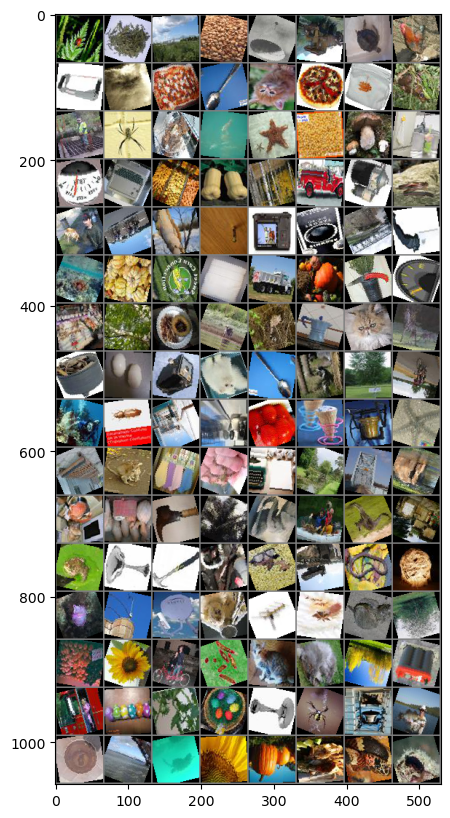

beetle   tea bridge  bean  bomb truck turtle  bird   saw   cat pizza spoon   cat pizza towel  frog bridge spider  crab turtle echinoderm  corn fungus towel gauge printer bread squash birch truck motor snake  crab bicycle birch battery camera camera bridge   saw turtle squash  corn towel truck squash   saw gauge  crab birch squash kangaroo  nest   pot   cat kangaroo   pot   egg camera   cat spoon monkey birch bicycle turtle  worm bridge camera tomato icecream acoustic echinoderm bridge kangaroo towel echinoderm printer bridge bridge elephant  crab squash   saw  palm elephant  crab kangaroo memorial  frog spoon hammer gauge  corn bridge snake  nest  worm gauge antenna icecream antenna spice turtle birch squash flower bicycle bacteria   cat   cat birch battery truck   egg tomato   egg spoon spider acoustic  fish memorial bridge turtle flower squash  crab snake  worm


In [5]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (20,10))

# get some random training images
images, labels = next(iter(train_loader))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images))

classes = full_dataset_augmented.classes

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

Niezbalansowanie klas nie jest duże

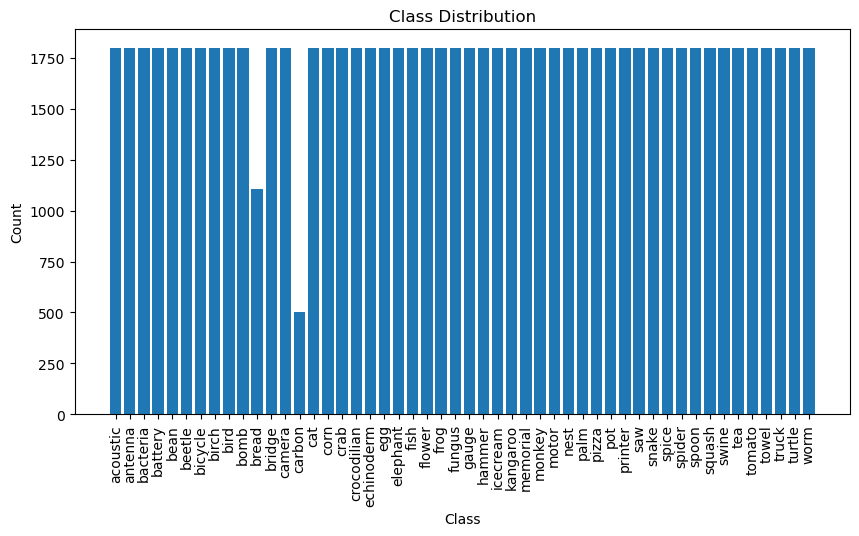

In [6]:
# Make plot of sizes of each class
class_counts = np.zeros(len(full_dataset_clean.classes))
for _, label in full_dataset_clean:
    class_counts[label] += 1

plt.figure(figsize=(10, 5))
plt.bar(range(len(class_counts)), class_counts)
plt.xticks(range(len(class_counts)), full_dataset_clean.classes, rotation=90)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1a = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn1a = nn.BatchNorm2d(128)
        self.conv1b = nn.Conv2d(128, 128, 3, padding=1)
        self.bn1b = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2a = nn.Conv2d(128, 256, 3, padding=1)
        self.bn2a = nn.BatchNorm2d(256)
        self.conv2b = nn.Conv2d(256, 256, 3, padding=1)
        self.bn2b = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2) 

        self.conv3a = nn.Conv2d(256, 512, 3, padding=1)
        self.bn3a = nn.BatchNorm2d(512)
        self.conv3b = nn.Conv2d(512, 512, 3, padding=1)
        self.bn3b = nn.BatchNorm2d(512)
        self.conv3c = nn.Conv2d(512, 512, 3, padding=1) 
        self.bn3c = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2) 

        self.conv4a = nn.Conv2d(512, 512, 3, padding=1)
        self.bn4a = nn.BatchNorm2d(512)
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)
        self.bn4b = nn.BatchNorm2d(512)
        self.conv4c = nn.Conv2d(512, 512, 3, padding=1) 
        self.bn4c = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2) 

        self.conv5a = nn.Conv2d(512, 1024, 3, padding=1) 
        self.bn5a = nn.BatchNorm2d(1024)
        self.conv5b = nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn5b = nn.BatchNorm2d(1024)

        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(1024, 2048)
        self.bn_fc1 = nn.BatchNorm1d(2048)
        self.dropout1 = nn.Dropout(0.5) 

        self.fc2 = nn.Linear(2048, 1024)
        self.bn_fc2 = nn.BatchNorm1d(1024)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(1024, 50)

    def forward(self, x):
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = F.relu(self.bn3c(self.conv3c(x)))
        x = self.pool3(x)

        x = F.relu(self.bn4a(self.conv4a(x)))
        x = F.relu(self.bn4b(self.conv4b(x)))
        x = F.relu(self.bn4c(self.conv4c(x)))
        x = self.pool4(x)

        x = F.relu(self.bn5a(self.conv5a(x)))
        x = F.relu(self.bn5b(self.conv5b(x)))

        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1) 

        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn_fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)

        return x


net = Net().to(device)
net

Net(
  (conv1a): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1a): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1b): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2a): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2b): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3a): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=Tr

In [8]:
# Print number of parameters
params_sum = 0
for params in net.parameters():
    params_sum+=params.view(-1).size(0)
params_sum

32439986

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

[1/50] Train loss: 3.056
Validation loss: 2.721
Validation accuracy: 26.94%
[2/50] Train loss: 2.470
Validation loss: 2.278
Validation accuracy: 37.26%
[3/50] Train loss: 2.164
Validation loss: 2.032
Validation accuracy: 43.81%
[4/50] Train loss: 1.946
Validation loss: 1.832
Validation accuracy: 49.02%
[5/50] Train loss: 1.783
Validation loss: 1.738
Validation accuracy: 51.78%
[6/50] Train loss: 1.659
Validation loss: 1.629
Validation accuracy: 54.61%
[7/50] Train loss: 1.549
Validation loss: 1.554
Validation accuracy: 56.44%
[8/50] Train loss: 1.468
Validation loss: 1.506
Validation accuracy: 58.15%
[9/50] Train loss: 1.392
Validation loss: 1.452
Validation accuracy: 60.61%
[10/50] Train loss: 1.329
Validation loss: 1.426
Validation accuracy: 61.07%
[11/50] Train loss: 1.269
Validation loss: 1.370
Validation accuracy: 62.66%
[12/50] Train loss: 1.217
Validation loss: 1.364
Validation accuracy: 63.04%
[13/50] Train loss: 1.169
Validation loss: 1.306
Validation accuracy: 63.39%
[14/50] 

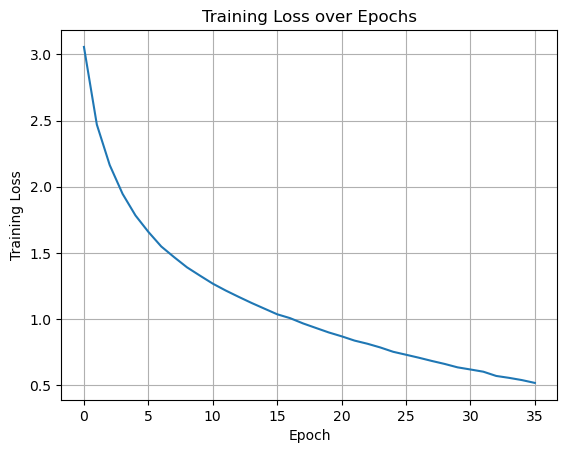

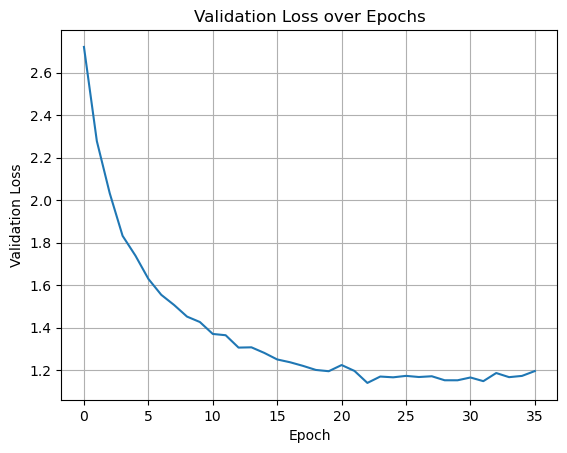

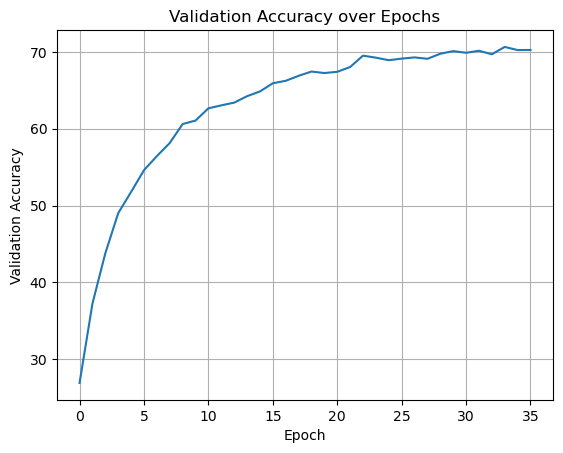

In [10]:
max_num_epochs = 50
patience = 5

validation_losses = []
validation_accuracies = []
train_losses = []

for epoch in range(max_num_epochs):

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    running_loss /= len(train_loader)
    print(f"[%d/{max_num_epochs}] Train loss: %.3f" % (epoch + 1, running_loss))
    train_losses.append(running_loss)

    # Validation - calculate loss
    validation_loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    validation_accuracy = 100 * correct / total
    validation_accuracies.append(validation_accuracy)
    validation_loss /= len(test_loader)

    # Early stopping
    if epoch > 0 and validation_loss >= validation_losses[-1] * 1.01: # minimum 1% increase
        patience -= 1

    validation_losses.append(validation_loss)
    print(f"Validation loss: {validation_loss:.3f}")
    print(f"Validation accuracy: {validation_accuracy:.2f}%")

    if patience == 0:
        print(f"Early stopping at epoch {epoch+1}")
        break

print("Finished Training")

# Plot training losses
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")
plt.grid()
plt.show()

# Plot validation losses
plt.plot(validation_losses)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss over Epochs")
plt.grid()
plt.show()

# Plot validation accuracies
plt.plot(validation_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.grid()
plt.show()

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        # calculate outputs by running images through the network 
        outputs = net(images).cpu()
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {(100 * correct / total):.2f} %')

Accuracy of the network on the test images: 70.68 %


In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        images = images.to(device)
        # calculate outputs by running images through the network 
        outputs = net(images).cpu()
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the train images: {(100 * correct / total):.2f} %')

Accuracy of the network on the train images: 85.41 %


In [13]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data    
        images = images.to(device)
        outputs = net(images).cpu()   
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

  
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))


Accuracy for class acoustic is: 58.1 %
Accuracy for class antenna is: 67.7 %
Accuracy for class bacteria is: 74.1 %
Accuracy for class battery is: 65.9 %
Accuracy for class bean  is: 71.6 %
Accuracy for class beetle is: 81.2 %
Accuracy for class bicycle is: 75.4 %
Accuracy for class birch is: 66.5 %
Accuracy for class bird  is: 53.3 %
Accuracy for class bomb  is: 72.2 %
Accuracy for class bread is: 54.1 %
Accuracy for class bridge is: 75.0 %
Accuracy for class camera is: 75.0 %
Accuracy for class carbon is: 48.9 %
Accuracy for class cat   is: 75.6 %
Accuracy for class corn  is: 54.5 %
Accuracy for class crab  is: 58.9 %
Accuracy for class crocodilian is: 61.9 %
Accuracy for class echinoderm is: 79.0 %
Accuracy for class egg   is: 65.4 %
Accuracy for class elephant is: 68.7 %
Accuracy for class fish  is: 69.8 %
Accuracy for class flower is: 94.7 %
Accuracy for class frog  is: 66.3 %
Accuracy for class fungus is: 81.2 %
Accuracy for class gauge is: 65.4 %
Accuracy for class hammer is: 84

In [14]:
# Save the model
state_dict = net.state_dict()
torch.save(state_dict, "big.mod")

In [18]:
import os
import csv
from torchvision.datasets.folder import default_loader

TEST_DIR = 'test_all/'
OUTPUT_CSV = 'pred.csv'
net.to(device)
net.eval()

predictions = []
all_entries = os.listdir(TEST_DIR)
test_files = [f for f in all_entries if os.path.isfile(os.path.join(TEST_DIR, f))]

with torch.no_grad():
    for filename in test_files:
        img_path = os.path.join(TEST_DIR, filename)
        img = default_loader(img_path)

        img_tensor = transform(img).unsqueeze(0).to(device)
        outputs = net(img_tensor)
        predicted_class_idx = torch.argmax(outputs, dim=1).item()
        predictions.append([filename, predicted_class_idx])

with open(OUTPUT_CSV, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(predictions)